# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:
* Тариф «Смарт»
    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей
    
* Тариф «Ультра»
    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей

> Примечание. «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

# Описание данных:

* Таблица users (информация о пользователях):
	* user_id — уникальный идентификатор пользователя
	* first_name — имя пользователя
	* last_name — фамилия пользователя
	* age — возраст пользователя (годы)
	* reg_date — дата подключения тарифа (день, месяц, год)
	* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
	* city — город проживания пользователя
	* tariff — название тарифного плана


* Таблица calls (информация о звонках):
	* id — уникальный номер звонка
	* call_date — дата звонка
	* duration — длительность звонка в минутах
	* user_id — идентификатор пользователя, сделавшего звонок


* Таблица messages (информация о сообщениях):
	* id — уникальный номер сообщения
	* message_date — дата сообщения
	* user_id — идентификатор пользователя, отправившего сообщение



* Таблица internet (информация об интернет-сессиях):
	* id — уникальный номер сессии
	* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
	* session_date — дата интернет-сессии
	* user_id — идентификатор пользователя


* Таблица tariffs (информация о тарифах):
	* tariff_name — название тарифа
	* rub_monthly_fee — ежемесячная абонентская плата в рублях
	* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
	* messages_included — количество сообщений в месяц, включённых в абонентскую плату
	* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
	* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
	* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
	* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение данных из файла

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')

In [3]:
# словарь датафреймов
dict_ds = {
    'calls': calls, 
    'internet': internet, 
    'messages': messages, 
    'tariffs': tariffs, 
    'users': users
}

for ds_name, ds in dict_ds.items():
    print(ds_name)
    display(ds)
    ds.info()
    print('___________________________')


calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
___________________________
internet


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
___________________________
messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
___________________________
tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
___________________________
users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
___________________________


### Вывод 
1. Пропусков в таблицах нет, за исключением churn_date в таблице users - если значение пропущено, то тариф ещё действовал на момент выгрузки данных. 
2. Обнаружены поля типа object, которые необходимо заменить на тип Datetime поменять типы на DataTime;
3. Обнаружены некоторые поля - поменять на int. 

## Подготовка данных

### Изменение типов данных

Полям users.reg_date, users.churn_date, messages.message_date, internet.session_date, calls.call_date поменяем типы на Datetime

In [4]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')

Проверим изменение типов

In [5]:
for ds_name, ds in dict_ds.items():
    print(ds_name)
    ds.info()
    print('\n\n')

calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB



internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1

В таблице calls округлим поле duration до минут методом math.ceil (округление в большую сторону)

In [6]:
calls['duration'] = calls['duration'].apply(math.ceil).astype(int)

In [7]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


In [8]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Unnamed: 0 - этого поля в описании задачи нету. Удалим его

In [9]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


### Проверка дубликатов

In [11]:
# функция для проверки уникальности
def check_unique(df, column):
    unique_column = len(df[column].unique())
    len_df = len(df)
    
    if unique_column != len_df:
        print('Идентификаторы датасета не уникальны')
    else:
        print('Идентификаторы датасета уникальны')

In [12]:
check_unique(users, 'user_id')

Идентификаторы датасета уникальны


In [13]:
check_unique(calls, 'id')

Идентификаторы датасета уникальны


In [14]:
check_unique(messages, 'id')

Идентификаторы датасета уникальны


In [15]:
check_unique(internet, 'id')

Идентификаторы датасета уникальны


### Подсчет показателей

Необходимо посчитать для каждого пользователя:
* Количество сделанных звонков и израсходованных минут разговора по месяцам;
* Количество отправленных сообщений по месяцам;
* Объем израсходованного интернет-трафика по месяцам;
* Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [16]:
# 1. Количество сделанных звонков и израсходованных минут разговора по месяцам;
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.groupby('month')['user_id'].agg(['count','sum'])

,count,sum
month,,
1,1476,1900961
2,3328,4256976
3,6687,8560788
4,9272,11683956
5,12647,15849201
6,14716,18353173
7,18298,22824233
8,21488,26879513
9,24061,30166590


В таблице internet округлим поле mb_used методом math.ceil (округление в большую сторону)

In [17]:
internet['mb_used'] = internet['mb_used'].apply(math.ceil).astype(int)

Количество звонков и минут увеличваются с каждым месяцем. Вероятно, это связано с тем, что люди поздравляют дург друга в канун Нового года.

In [18]:
# 2. Количество отправленных сообщений по месяцам;
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.groupby('month')['user_id'].count()

month
1       924
2      1924
3      3648
4      5179
5      7298
6      8983
7     11320
8     13088
9     14759
10    17114
11    18244
12    20555
Name: user_id, dtype: int64

Количество отправленных сообщений тоже растет с каждым месяцем.

In [19]:
# 3. Объем израсходованного интернет-трафика по месяцам;
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.groupby('month')['mb_used'].sum()

month
1      408213
2      956348
3     1813960
4     2436111
5     3529893
6     4184770
7     5035299
8     6005126
9     6454931
10    7400754
11    7999852
12    9144202
Name: mb_used, dtype: int64

Потребление интернет-трафика увеличивается с каждым месяцем.

Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [20]:
df_result = pd.DataFrame()

calls_grouped = calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
calls_grouped.columns = ['user_id', 'month', 'calls', 'min']

messages_grouped = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_grouped.columns = ['user_id', 'month', 'mes']

internet_grouped = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_grouped.columns = ['user_id', 'month', 'mb']

df_result = pd.merge(messages_grouped, calls_grouped, how='outer', on=['user_id', 'month'])
df_result = pd.merge(df_result, internet_grouped, how='outer', on=['user_id', 'month'])
df_result = pd.merge(df_result, users.loc[:,['user_id', 'city', 'tariff']], how='outer', on=['user_id'])

# Заменим пропуски для расчетов
df_result['calls'] = df_result['calls'].fillna(0)
df_result['min'] = df_result['min'].fillna(0)
df_result['mes'] = df_result['mes'].fillna(0)
df_result['mb'] = df_result['mb'].fillna(0)

In [21]:
def income_month(row):
    """
    Функция подсчета конечной выручки в зависимости от траффика
    """
    if row['tariff'] == 'smart':
        
        inc_calls = (row['min'] - tariffs.loc[0,'minutes_included']) * tariffs.loc[0,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (row['mes'] - tariffs.loc[0,'messages_included']) * tariffs.loc[0,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
        inc_mb  = math.ceil((row['mb'] - tariffs.loc[0,'mb_per_month_included'])/1024) * tariffs.loc[0,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
        return inc_calls + inc_mess + inc_mb + tariffs.loc[0,'rub_monthly_fee']
        
    else:
        inc_calls = (row['min'] - tariffs.loc[1,'minutes_included']) * tariffs.loc[1,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (row['mes'] - tariffs.loc[1,'messages_included']) * tariffs.loc[1,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
        inc_mb  = math.ceil((row['mb'] - tariffs.loc[1,'mb_per_month_included'])/1024) * tariffs.loc[1,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        return inc_calls + inc_mess + inc_mb + tariffs.loc[1,'rub_monthly_fee']


df_result['income'] = df_result.apply(income_month, axis=1)

In [22]:
df_result.head(100)

,user_id,month,mes,calls,min,mb,city,tariff,income
0,1000,5.0,22.0,22.0,159.0,2256.0,Краснодар,ultra,1950.0
1,1000,6.0,60.0,43.0,172.0,23257.0,Краснодар,ultra,1950.0
2,1000,7.0,75.0,47.0,340.0,14016.0,Краснодар,ultra,1950.0
3,1000,8.0,81.0,52.0,408.0,14070.0,Краснодар,ultra,1950.0
4,1000,9.0,57.0,58.0,466.0,14581.0,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
95,1015,9.0,68.0,64.0,486.0,16798.0,Челябинск,smart,1004.0
96,1015,10.0,68.0,67.0,577.0,16684.0,Челябинск,smart,1235.0
97,1015,11.0,61.0,51.0,454.0,21553.0,Челябинск,smart,1983.0
98,1015,12.0,74.0,64.0,499.0,19653.0,Челябинск,smart,1622.0


## Анализ данных

In [23]:
activity_month = df_result.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()
display(activity_month)

/tmp/ipykernel_69/1263952912.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  activity_month = df_result.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()


,tariff,month,min,mes,mb,income
0,smart,1.0,6931.0,620.0,289831.0,24525.0
1,smart,2.0,17324.0,1397.0,673461.0,48001.0
2,smart,3.0,30034.0,2453.0,1164537.0,89676.0
3,smart,4.0,41119.0,3443.0,1509702.0,107866.0
4,smart,5.0,54618.0,4762.0,2231353.0,169849.0
5,smart,6.0,64885.0,5478.0,2593622.0,198259.0
6,smart,7.0,82079.0,6784.0,3168466.0,247014.0
7,smart,8.0,99045.0,7905.0,3908561.0,312340.0
8,smart,9.0,111439.0,8746.0,4244377.0,326386.0
9,smart,10.0,125284.0,9927.0,4932898.0,402667.0


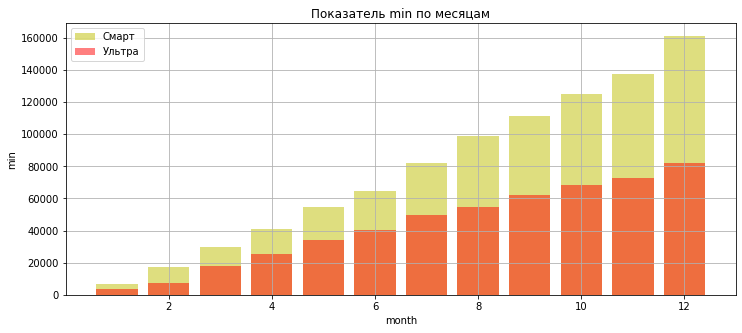

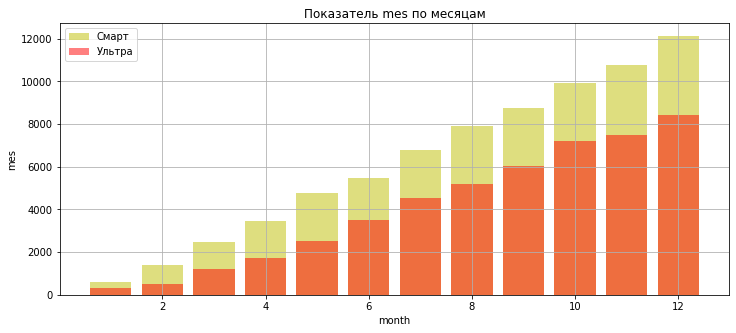

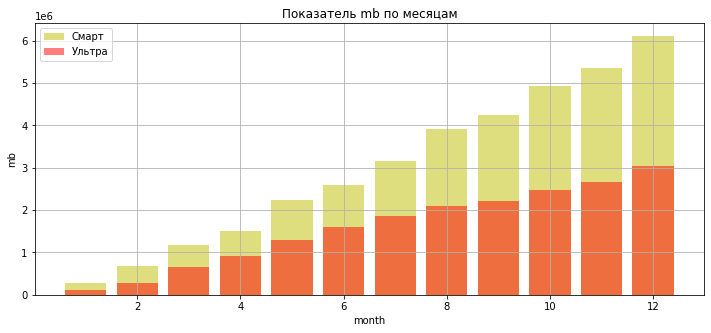

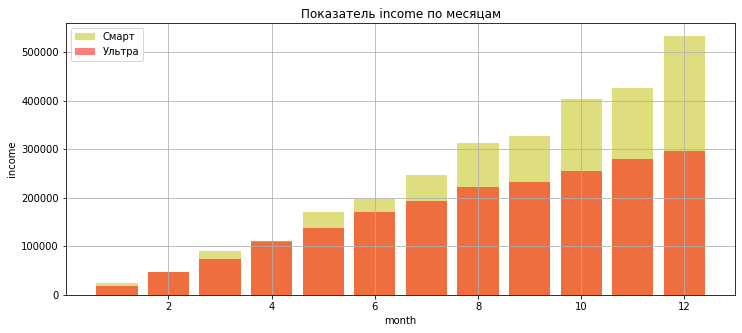

In [24]:
activity_month_smart = activity_month.query('tariff=="smart"')
activity_month_ultra = activity_month.query('tariff=="ultra"')

for param in ['min', 'mes', 'mb','income']:
    plt.figure(figsize=(12, 5))
    
    plt.bar(activity_month_smart['month'], activity_month_smart[param], label='Смарт', color='y', alpha=0.5)
    plt.bar(activity_month_ultra['month'], activity_month_ultra[param], label='Ультра', color='r', alpha=0.5)
    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Показатель {param} по месяцам')
    plt.legend()
    plt.show();

# Вывод
1. Из графиков видно, что общий расход по минутам, сообщениям и по интернету всех абонентов тарифа «Смарт» больше, чем у тарифа «Ультра».
2. В первой половине года абоненты по обоим тарифам приносят почти одинаковую выручку, а во второй половине - у тарифа «Смарт» выручка начинает значительно превышать выручку тарифа «Ультра». 
3. По всем графикам видно, что выручка растет с каждым месяцем - связано с притоком абонентов каждый месяц.

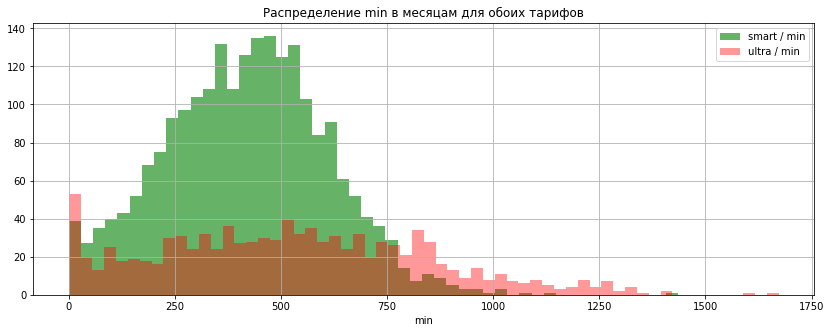

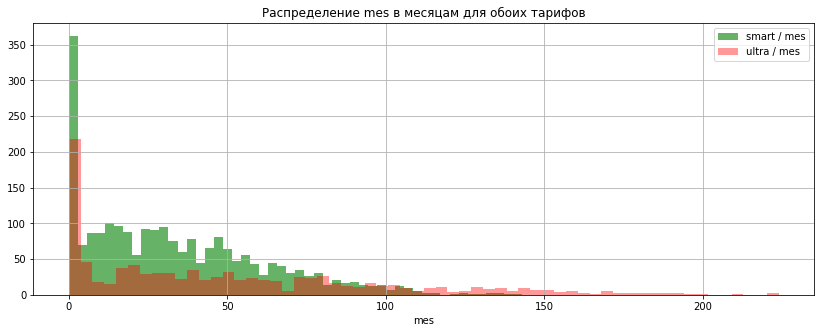

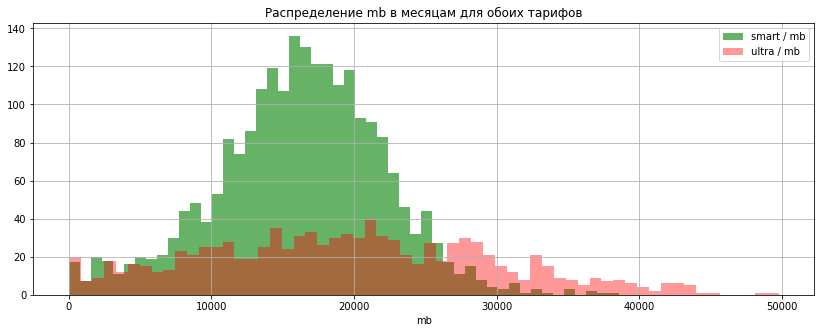

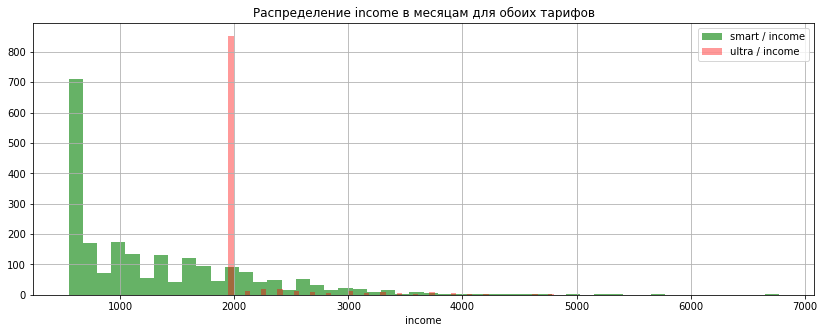

In [25]:
for param in ['min', 'mes', 'mb','income']:
    plt.figure(figsize=(14, 5))
    
    plt.hist(df_result.loc[df_result['tariff'] == "smart", param], label='smart / '+param, color='g', alpha=0.6, bins = 50)
    plt.hist(df_result.loc[df_result['tariff'] == "ultra", param], label='ultra / '+param, color='r', alpha=0.4, bins = 60)
    
    plt.xlabel(param)
    plt.grid()
    plt.title(f'Распределение {param} в месяцам для обоих тарифов')
    plt.legend()
    plt.show();

# Вывод
1. В тарифе «Смарт» большинство абонентов укладываются в лимит 500 минут разговора, 50 собщений, а вот интернет-трафика в 15 Гб  часто не достаточно из-за этого абоненты платят сверх ежемесячный платы.
2. В тарифе «Ультра» всем хватает 3000 минут разговора, 1000 сообщений, в лимит интернет-трафика в 30 Гб многие укладываются, поэтому абоненты платят стандартную ежемесячную плату: 1950 рублей.

Считаем среднее, дисперсию и стандартное отклонение.

In [26]:
functions = ['mean', np.var, np.std] # Функции, применяемые к значениям
tables = ['total_month_sum_mean', 'total_month_sum_var', 'total_month_sum_std'] # Названия сводных таблиц
list_of_cols = ['min', 'mes', 'mb','income']

for i in range(0, 3):
    tables[i] = df_result.pivot_table(index=['tariff'], values=list_of_cols, aggfunc=functions[i])
    tables[i].columns = ['calls_duration', 'messages_count', 'traffic_volume', 'total_bill']
    display(tables[i])

,calls_duration,messages_count,traffic_volume,total_bill
tariff,,,,
smart,1294.305381,16221.910762,33.369058,417.747534
ultra,2070.943205,19467.137931,49.313387,526.089249


,calls_duration,messages_count,traffic_volume,total_bill
tariff,,,,
smart,673877.623614,3.464852e+07,796.955256,36281.393836
ultra,143360.429258,1.022173e+08,2285.417425,101052.493549


,calls_duration,messages_count,traffic_volume,total_bill
tariff,,,,
smart,820.900496,5886.299627,28.230396,190.476754
ultra,378.629673,10110.255401,47.806040,317.887549


# Вывод

* В среднем пользователи тарифа «Ультра» больше пользуются услугами оператора, чем пользователи тарифа «Смарт».
* По дисперсии видно, что пользователи выбирают тариф «Ультра», т.к. там больше мегабайт трафика, потому что люди сейчас даже звонят через интернет или по видеосвязи и сообщениями пользуются в социальных сетях.

## Проверка гипотез

> 1 гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра»и «Смарт» равны.

Альтернативная гипотеза : средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [27]:
alpha = .05 # критический уровень статистической значимости

smart_hip = df_result.query('tariff == "smart"')
smart_hip = smart_hip['income']

ultra_hip = df_result.query('tariff == "ultra"')
ultra_hip = ultra_hip['income']  

results = st.ttest_ind(
    smart_hip, 
    ultra_hip)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7023268870436946e-158
Отвергаем нулевую гипотезу


# Вывод

По результату видно, что нулевая отвергается, а значит мы подтверждаем первую гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

> 2 гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [28]:
alpha = .05 # критический уровень статистической значимости

moskow = df_result.query('city == "Москва"')
moskow = moskow['income']

other_city = df_result.query('city != "Москва"')
other_city = other_city['income']  

result = st.ttest_ind(
    moskow, 
    other_city)

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу


# Вывод
Отвергнуть нулевую гипотезу не получилось, значит вторая гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтверждается.

## Общий вывод

Сделав предварительный анализ тарифов на небольшой выборке клиентов, можно сказать, что:
1. Количество звонков и минут, отправленных сообщений, потребление интернет-трафика однозначно увеличиваются с каждым месяцем(достигают пика в декабре).
2. Выручка тарифа «Смарт» превышает выручку тарифа «Ультра». Так что, возможно, компании «Мегалайн» нужно больше ориентироватсья на пользователей тарифа «Смарт».
3. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, значит компания не привязана к территориальной местности.